### Contents:

* **Setup**
    * [Import and Load](#IMPORT)
    * [Configure Presets](#CONFIGURE_PRESETS)
* [**Data Preparation**](#DATA_PREPARATION)
* **Feature Engineering**
    * [New Columns](#NEW_COLUMNS)
    * [Dummy Variables](#DUMMY_VARIABLES)
* [**Data Cleansing**](#DATA_CLEANSING)
* [**Model Assembly**](#MODEL_ASSEMBLY)
* [**=> Submission**](#SUBMISSION)

---
### Setup

<a id='IMPORT'></a>
##### **IMPORT AND LOAD**

In [1]:
import pandas as pd
import numpy as np

from datetime import datetime as dt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

In [2]:
df_train = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')

df_test.drop('Name', axis=1, inplace=True)

# In order to process the features correctly let's combine Train and Test into one dataset:
df_train['sample'] = 1  # label for Train
df_test['sample'] = 0  # label for Test
df_test['Rating'] = 0  # target variable

df = df_test.append(df_train, sort = False).reset_index(drop=True)

<a id='CONFIGURE_PRESETS'></a>
##### **CONFIGURE PRESETS**

In [3]:
# Version of the solution
VERSION = 1.0

# Fix random seed constant and packets versions
RANDOM_SEED = 42
!pip freeze > requirements.txt

# Define helper rounding function
round_rate = lambda x: round(x * 2) / 2
vfunc = np.vectorize(round_rate)

# Prepare datetime parser
datetimify = lambda s: dt.strptime(s, '%m/%d/%Y')
def is_date(s):
    try:
        datetimify(s)
        return True
    except ValueError:
        return False

# Capital cities list
capitals = ['Paris', 'Stockholm', 'London', 'Berlin', 'Bratislava', 
            'Vienna', 'Rome', 'Madrid', 'Dublin', 'Brussels', 'Warsaw', 
            'Budapest', 'Copenhagen', 'Amsterdam', 'Lisbon', 'Prague', 
            'Oslo', 'Helsinki', 'Edinburgh', 'Ljubljana', 'Athens', 'Luxembourg']

# Cities population dict
cities_population = {
    'Paris': 2140526, 'Stockholm': 965232, 'London': 8908081, 'Berlin': 3748148, 
    'Munich': 1456039, 'Oporto': 214349, 'Milan': 1385023,'Bratislava': 432864, 
    'Vienna': 1888776, 'Rome': 4355725, 'Barcelona': 1620343, 'Madrid': 3223334, 
    'Dublin': 1173179,'Brussels': 1191604, 'Zurich': 428737, 'Warsaw': 1783321, 
    'Budapest': 1750268, 'Copenhagen': 1000218, 'Amsterdam': 1380872,'Lyon': 506615, 
    'Hamburg': 1841179,'Lisbon': 505526, 'Prague': 1309182, 'Oslo': 673469, 
    'Helsinki': 648042, 'Edinburgh': 518500, 'Geneva': 201741, 'Ljubljana': 288250, 
    'Athens': 664046, 'Luxembourg': 115227, 'Krakow': 771069
}

words_weights = {
    'excellent': 1, 
    'ex': 1, 
    'great': 1, 
    'good': 1, 
    'bad': -1
}

words_attributes = {}

# Cuisines Groups dict
cuisines_groups = {
    'European': ['European', 'Pizza'], 
    'French': ['French'], 
    'Bar': ['Bar'], 
    'Special': ['Vegetarian Friendly', 'Vegan Options', 'Gluten Free Options', 'Healthy']
}

<a id='DATA_PREPARATION'></a>

---
### Data Preparation

In [4]:
# Convert 'Cuisine Style' column values to list
listify_cuisines = lambda s: s[1:-1].replace("'", "").split(", ")\
                             if not pd.isnull(s) else ['null']
df['Cuisine Style'] = df['Cuisine Style'].apply(listify_cuisines)

# Make "all cuisine types" list
cuisines = []
for s in df['Cuisine Style']:
    for c in s:
        if not c in cuisines:
            cuisines.append(c)

# Make dict with cuisines prevalence among restaurants
cuisines_rests = {}
for cu in cuisines:
    cuisines_rests.update({cu : 0})
    
for i in range(0, df['Cuisine Style'].count()):
    df_cu = df['Cuisine Style'].iloc[i]
    if not df_cu == []:
        for cu in cuisines:
            if cu in df_cu:
                cuisines_rests[cu] += 1
                
for cu in cuisines_rests.items():
    cuisines_rests[cu[0]] = round(cu[1] / 1000)
    
# Split "Reviews" column into "Only Reviews" and "Only Dates" columns
listify_reviews = lambda s: s[1:-1].replace("'", "").split(", ")\
                            if not pd.isnull(s) else []
clear_strings = lambda l: [s.strip('[]') for s in l]
df['Reviews'] = df['Reviews'].apply(listify_reviews).apply(clear_strings)

# Define helper func for preprocessing "Reviews" column
def get_review_dates_strs(l, get_dates=True):
    dates = []
    reviews = []
    for s in l:
        if is_date(s):
            dates.append(datetimify(s))
        else:
            reviews.append(s)
    return dates if get_dates else reviews

df.insert(7, 'Only Reviews', df['Reviews'].apply(lambda x: get_review_dates_strs(x, get_dates=False)))
df.insert(8, 'Only Dates', df['Reviews'].apply(lambda x: get_review_dates_strs(x, get_dates=True)))

---
### Feature Engineering

<a id='NEW_COLUMNS'></a>
##### **NEW COLUMNS**

In [5]:
# Add column representing whether the restaurant is situated in a capital city
is_capital = lambda x: 1 if x in capitals else 0
df.insert(2, '[+] Is Capital', df['City'].apply(is_capital))

# Add city population column
df.insert(3, '[+] Population', df['City'].map(cities_population))

# Add 'Cuisines Count' column (representing number of cuisines in offer)
count_cuisines = lambda l: 1 if len(l) == 0 else len(l)
df.insert(5, '[+] Cuisines Count', df['Cuisine Style'].apply(count_cuisines))

# Add numeric representation of 'Price Range' column
price_masks = {'$': 1, '$$ - $$$': 2.5, '$$$$': 4}
df.insert(9, '[+] Prices Numeric', df['Price Range'].map(price_masks))

# Add column for days span between reviews
count_days_span = lambda x: None if len(x) == 0 else abs(x[len(x) - 1] - x[0]).days
df.insert(13, '[+] Days Span', df['Only Dates'].apply(count_days_span))

# Add column with number of days lasted from last review
count_days_fromlast = lambda x: None if len(x) == 0 else abs(max(x) - dt.today()).days
df.insert(14, '[+] Days From Last Review', df['Only Dates'].apply(count_days_fromlast))

# Add column with reviews score
get_score = lambda r: sum([r.count(w) * words_weights[w] for w in words_weights])
ParseReviews = lambda reviews: sum([get_score(r.lower()) for r in reviews])

df['[+] Reviews Score'] = df['Reviews'].apply(ParseReviews)

<a id='DUMMY_VARIABLES'></a>
##### **DUMMY VARIABLES**

In [6]:
# Add dummy variables for each city
df = pd.get_dummies(df, columns=['City'], prefix="[d] [City]", prefix_sep=" ", dummy_na=True)

# Add dummy variables for cuisines groups
for col in cuisines_groups.keys():
    df.insert(len(df.columns), col, 0)

get_cuisine_groups = lambda cu: [gr for gr in cuisines_groups.keys() 
                                 if cu in cuisines_groups[gr]]

def categorize_cuisine(cu, i):
    for gr in get_cuisine_groups(cu):
        df[gr][i] = 1
        
for i in range(df['Cuisine Style'].count()):
    for c in df['Cuisine Style'][i]:
        categorize_cuisine(c, i)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [7]:
# Values dimension optimization

df['Ranking'] = df['Ranking'] / df['[+] Population']

In [8]:
# -- ABSOLUTE RANDOM HACKS

# Convert column with page ID_TA to it's numeric length
df['ID_TA'] = df['ID_TA'].apply(lambda s: len(s))

<a id='DATA_CLEANSING'></a>

---
### Data Cleansing

In [9]:
### AVOID NONE-VALUES
# Replace all NaN values of the "Number of Reviews" column with 0
reviews_mean = df['Number of Reviews'].min()
df = df.fillna({'Number of Reviews': reviews_mean})

df['[+] Number of Reviews [isNAN]'] = pd.isna(df['Number of Reviews']).astype('uint8')
df = df.fillna({'Number of Reviews': 0})

# Replace all NaN values of the "[+] Prices Numeric" column with mean() value
prices_mean = df['[+] Prices Numeric'].mean()
df = df.fillna({'[+] Prices Numeric': prices_mean})

# Replace all NaN values of the "[+] Days Span" column with 0
df['[+] Days Span [isNAN]'] = pd.isna(df['[+] Days Span']).astype('uint8')
df = df.fillna({'[+] Days Span': 0})

# Replace all NaN values of the "[+] Days From Last Review" column with 0
df['[+] Days From Last Review [isNAN]'] = pd.isna(df['[+] Days From Last Review']).astype('uint8')
df = df.fillna({'[+] Days From Last Review': 0})

### OMIT NON-NUMERICAL FEATURES
# Exclude all columns with non-numerical dtypes
df = df.select_dtypes(exclude = ['object'])

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 51 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   [+] Is Capital                     50000 non-null  int64  
 1   [+] Population                     50000 non-null  int64  
 2   [+] Cuisines Count                 50000 non-null  int64  
 3   Ranking                            50000 non-null  float64
 4   Number of Reviews                  50000 non-null  float64
 5   [+] Prices Numeric                 50000 non-null  float64
 6   [+] Days Span                      50000 non-null  float64
 7   [+] Days From Last Review          50000 non-null  float64
 8   ID_TA                              50000 non-null  int64  
 9   sample                             50000 non-null  int64  
 10  Rating                             50000 non-null  float64
 11  [+] Reviews Score                  50000 non-null  int

<a id='MODEL_ASSEMBLY'></a>

---
### Model Assembly

In [11]:
# Generate train data back
train_data = df.query('sample == 1').drop(['sample'], axis=1)

# Х - data, 
# у - target value ('Rating')
X = train_data.drop(['Rating'], axis=1)
y = train_data['Rating']

# Split data to Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=RANDOM_SEED)


# Train and fit a Random Forest Regressor model on the Train data
model = RandomForestRegressor(n_estimators=100, 
                              verbose=1, 
                              n_jobs=-1, 
                              random_state=RANDOM_SEED)
model.fit(X_train, y_train)

# Predict ratings and round them
y_pred = vfunc(model.predict(X_test))

print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.8s


MAE: 0.1684375


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


<a id='SUBMISSION'></a>

---
### ↥ Submission

In [12]:
model.fit(X, y)

test_data = df.query('sample == 0').drop(['sample'], axis=1)
test_data = test_data.drop(['Rating'], axis=1)
y_pred_submission = vfunc(model.predict(test_data))

submission = pd.read_csv('sample_submission.csv')
submission['Rating'] = y_pred_submission

now = dt.now().strftime('[%d.%m.%Y]-[%H-%M]')
submission.to_csv(f'submission_v{VERSION}-{now}.csv', index=False)

submission.head(10)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.0
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5
5,id_5,4.5
6,id_6,1.0
7,id_7,2.5
8,id_8,4.0
9,id_9,4.5


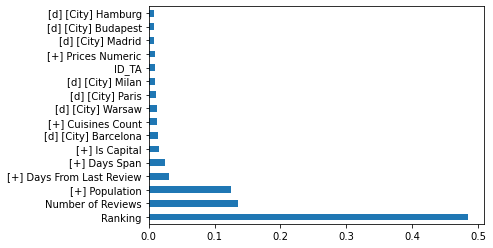

In [13]:
##
## Feature Importance checkout
##

import matplotlib as plt

plt.rcParams.update({'font.size': 22, 'xtick.color': 'black', 'ytick.color': 'black'})
plt.rcParams['figure.figsize'] = (20, 10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(16).plot(kind='barh');